In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brazilian-ecommerce/olist_customers_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_sellers_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_order_reviews_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_order_items_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_products_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_geolocation_dataset.csv
/kaggle/input/brazilian-ecommerce/product_category_name_translation.csv
/kaggle/input/brazilian-ecommerce/olist_orders_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_order_payments_dataset.csv


# **IMPORTS**

In [2]:
# Standard libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.gridspec import GridSpec
pd.set_option('display.max_columns', 100)
import plotly.offline as py
import plotly.express as px
import plotly.graph_objs as go
import json
import requests
import folium
from folium.plugins import FastMarkerCluster, Fullscreen, MiniMap, HeatMap, HeatMapWithTime, LocateControl
from wordcloud import WordCloud
from collections import Counter
from PIL import Image




# DataPrep
import re
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import joblib




 # Modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import lightgbm as lgb

In [3]:
# getting the files
raw_path = '/kaggle/input/brazilian-ecommerce/'
olist_customer = pd.read_csv(raw_path + 'olist_customers_dataset.csv')
olist_geolocation = pd.read_csv(raw_path + 'olist_geolocation_dataset.csv')
olist_orders = pd.read_csv(raw_path + 'olist_orders_dataset.csv')
olist_order_items = pd.read_csv(raw_path + 'olist_order_items_dataset.csv')
olist_order_payments = pd.read_csv(raw_path + 'olist_order_payments_dataset.csv')
olist_order_reviews = pd.read_csv(raw_path + 'olist_order_reviews_dataset.csv')
olist_products = pd.read_csv(raw_path + 'olist_products_dataset.csv')
olist_sellers = pd.read_csv(raw_path + 'olist_sellers_dataset.csv')



In [4]:

def dataframe_report(df_list, df_names=None):
    """
    Returns a dataframe summarizing shape and null stats for a list of dataframes.
    
    Parameters:
    - df_list: list of pandas DataFrames
    - df_names: optional list of dataframe names (as strings). If None, uses generic names.
    
    Returns:
    - pd.DataFrame
    """
    if df_names is None:
        df_names = [f"df_{i}" for i in range(len(df_list))]
    
    report = []

    for df, name in zip(df_list, df_names):
        n_rows, n_cols = df.shape
        null_counts = df.isnull().sum()
        total_nulls = null_counts.sum()
        pct_nulls = round((total_nulls / (n_rows * n_cols)) * 100, 2) if n_rows * n_cols else 0
        null_columns = null_counts[null_counts > 0].index.tolist()
        report.append({
            'dataset': name,
            'n_rows': n_rows,
            'n_cols': n_cols,
            'null_amount (%)': pct_nulls,
            'qty_null_columns': len(null_columns),
            'null_columns': ', '.join(null_columns) if null_columns else ''
        })
    
    return pd.DataFrame(report)

In [5]:
df_list = [olist_customer, olist_geolocation,olist_orders, olist_order_items, olist_order_payments,
        olist_order_reviews, olist_products, olist_sellers]
df_names = ["olist_customer", "olist_geolocation","olist_orders", "olist_order_items", "olist_order_payments",
        "olist_order_reviews", "olist_products", "olist_sellers"]

In [6]:
report = dataframe_report(df_list, df_names)
report

,dataset,n_rows,n_cols,null_amount (%),qty_null_columns,null_columns
0,olist_customer,99441,5,0.00,0,
1,olist_geolocation,1000163,5,0.00,0,
2,olist_orders,99441,8,0.62,3,"order_approved_at, order_delivered_carrier_dat..."
3,olist_order_items,112650,7,0.00,0,
4,olist_order_payments,103886,5,0.00,0,
5,olist_order_reviews,99224,7,21.01,2,"review_comment_title, review_comment_message"
6,olist_products,32951,9,0.83,8,"product_category_name, product_name_lenght, pr..."
7,olist_sellers,3095,4,0.00,0,


In [7]:
def columnwise_report(df_list, df_names=None, cat_threshold=20):
    """
    Generate a multi-index report of column-level info per dataframe.

    Parameters:
    - df_list: list of pandas DataFrames
    - df_names: optional list of dataframe names. If None, names are auto-generated.
    - cat_threshold: max unique values for a column to be counted as 'categorical'
    
    Returns:
    - pd.DataFrame with MultiIndex: [dataset_name, column_name]
    """
    if df_names is None:
        df_names = [f"df_{i}" for i in range(len(df_list))]

    rows = []

    for df, name in zip(df_list, df_names):
        n_rows = len(df)
        for col in df.columns:
            null_count = df[col].isnull().sum()
            null_pct = round((null_count / n_rows) * 100, 2) if n_rows else 0
            dtype = df[col].dtype
            # Categorical is defined by threshold on unique values
            n_categorical_values = df[col].nunique() if df[col].dtype == 'object' else 0
            rows.append(((name, col), {
                'null_count': null_count,
                'null_pct': null_pct,
                'dtype': dtype,
                'n_categorical_values': n_categorical_values
            }))

    multi_index = pd.MultiIndex.from_tuples([row[0] for row in rows], names=['dataset', 'column'])
    data = [row[1] for row in rows]

    return pd.DataFrame(data, index=multi_index)

In [8]:
column_report = columnwise_report(df_list, df_names, cat_threshold = 4000)
column_report

null_count  null_pct  \
dataset              column                                                
olist_customer       customer_id                             0      0.00   
                     customer_unique_id                      0      0.00   
                     customer_zip_code_prefix                0      0.00   
                     customer_city                           0      0.00   
                     customer_state                          0      0.00   
olist_geolocation    geolocation_zip_code_prefix             0      0.00   
                     geolocation_lat                         0      0.00   
                     geolocation_lng                         0      0.00   
                     geolocation_city                        0      0.00   
                     geolocation_state                       0      0.00   
olist_orders         order_id                                0      0.00   
                     customer_id                             0      0.00   
                     order_status                            0      0.00   
                     order_purchase_timestamp                0      0.00   
                     order_approved_at                     160      0.16   
                     order_delivered_carrier_date         1783      1.79   
                     order_delivered_customer_date        2965      2.98   
                     order_estimated_delivery_date           0      0.00   
olist_order_items    order_id                                0      0.00   
                     order_item_id                           0      0.00   
                     product_id                              0      0.00   
                     seller_id                               0      0.00   
                     shipping_limit_date                     0      0.00   
                     price                                   0      0.00   
                     freight_value                           0      0.00   
olist_order_payments order_id                                0      0.00   
                     payment_sequential                      0      0.00   
                     payment_type                            0      0.00   
                     payment_installments                    0      0.00   
                     payment_value                           0      0.00   
olist_order_reviews  review_id                               0      0.00   
                     order_id                                0      0.00   
                     review_score                            0      0.00   
                     review_comment_title                87656     88.34   
                     review_comment_message              58247     58.70   
                     review_creation_date                    0      0.00   
                     review_answer_timestamp                 0      0.00   
olist_products       product_id                              0      0.00   
                     product_category_name                 610      1.85   
                     product_name_lenght                   610      1.85   
                     product_description_lenght            610      1.85   
                     product_photos_qty                    610      1.85   
                     product_weight_g                        2      0.01   
                     product_length_cm                       2      0.01   
                     product_height_cm                       2      0.01   
                     product_width_cm                        2      0.01   
olist_sellers        seller_id                               0      0.00   
                     seller_zip_code_prefix                  0      0.00   
                     seller_city                             0      0.00   
                     seller_state                            0      0.00   

                                                      dtype  \
dataset              column         

# **EDA**

In [9]:
def plot_bar_percent(df, col, show_pct_labels=True, order=None, palette='pastel'):
    # Get value counts as percentages
    pct = df[col].value_counts(normalize=True).sort_index() * 100
    pct = pct.sort_values(ascending=False) if order is None else pct[order]

    # Plot
    ax = sns.barplot(x=pct.index, y=pct.values, palette=palette)
    plt.title(f'Percentage Distribution of {col}', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Percentage (%)', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add percentage labels on top of bars
    if show_pct_labels:
        for patch, value in zip(ax.patches, pct.values):
            ax.annotate(f'{value:.1f}%', 
                        (patch.get_x() + patch.get_width() / 2, patch.get_height()), 
                        ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # 💡 Auto-scale figsize based on number of bars
    num_categories = len(pct)
    width = max(6, num_categories * 0.7)
    plt.gcf().set_size_inches(width, 5)
    plt.show()

# *Total Orders on E-Commerce*

* *How many orders we have for each status?*

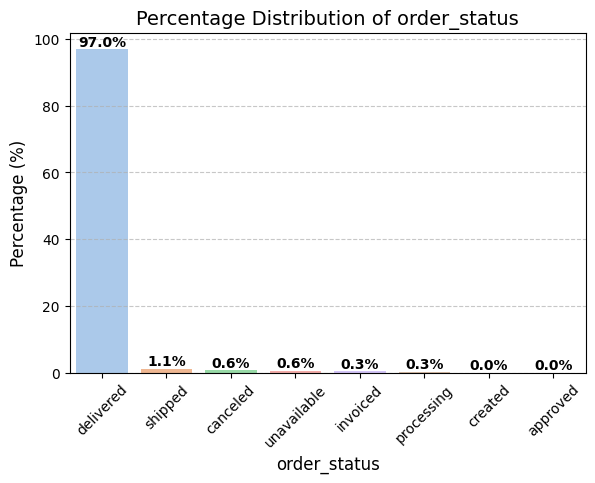

In [10]:
plot_bar_percent(olist_orders, 'order_status')

* Mostly delivered. Only 3% of all orders came from the other status.  

* *Is that a growing trend on e-commerce in Brazil?*

In [11]:
def date_breakdown(df, date):
    # Ensure the 'date' column is in datetime format
    df[date] = pd.to_datetime(df[date])
    
    df["weekday"] = df[date].dt.dayofweek
    df['weekday_name'] = df[date].dt.strftime('%A')
    df['month'] = df[date].dt.month
    df['month_name'] = df[date].dt.strftime('%B')
    df['quarter'] = df[date].dt.quarter
    df['year'] = df[date].dt.year
    df['week_of_year'] = df[date].dt.isocalendar().week
    df['day_of_year'] = df[date].dt.dayofyear
    
    return df

In [12]:
def plot_quarterly_order_trend(df, order_date_col, order_id_col, title="Quarterly Order Volume Trend"):
    """
    Plots net order volume per quarter across years.

    Parameters:
    - df: pandas DataFrame
    - order_date_col: str, column name containing order datetime
    - order_id_col: str, column name containing unique order IDs
    - title: str, plot title
    """

    # Ensure datetime
    df = df.copy()
    df[order_date_col] = pd.to_datetime(df[order_date_col], errors='coerce')

    # Drop rows with invalid dates
    df = df.dropna(subset=[order_date_col])

    # Extract year and quarter
    df['year'] = df[order_date_col].dt.year
    df['quarter'] = df[order_date_col].dt.quarter

    # Group and count unique orders
    trend = (df.groupby(['year', 'quarter'])[order_id_col]
             .nunique()
             .reset_index()
             .rename(columns={order_id_col: 'order_count'}))

    # For plotting aesthetics
    trend['year_quarter'] = trend['year'].astype(str) + ' Q' + trend['quarter'].astype(str)

    # Plotting
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=trend, x='year_quarter', y='order_count', marker='o')
    plt.title(title)
    plt.xlabel('Year-Quarter')
    plt.ylabel('Unique Orders')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [13]:
def plot_order_volume_patterns(df, order_date_col, order_id_col):
    """
    Plots order volume trends across weekdays and parts of the day,
    with percentage labels on top of each bar.
    
    Parameters:
    - df: pandas DataFrame
    - order_date_col: str, datetime column name
    - order_id_col: str, unique order ID column name
    """

    df = df.copy()
    df[order_date_col] = pd.to_datetime(df[order_date_col], errors='coerce')
    df = df.dropna(subset=[order_date_col])

    # --- Weekday Analysis ---
    df['weekday'] = df[order_date_col].dt.day_name()
    weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    weekday_trend = df.groupby('weekday')[order_id_col].nunique().reindex(weekday_order).reset_index()
    weekday_trend.columns = ['weekday', 'order_count']
    weekday_total = weekday_trend['order_count'].sum()
    weekday_trend['pct'] = round((weekday_trend['order_count'] / weekday_total) * 100, 1)

    # --- Part of Day Analysis ---
    df['hour'] = df[order_date_col].dt.hour

    def get_part_of_day(hour):
        if 5 <= hour < 9:
            return 'Dawn'
        elif 9 <= hour < 12:
            return 'Morning'
        elif 12 <= hour < 17:
            return 'Afternoon'
        elif 17 <= hour < 21:
            return 'Evening'
        else:
            return 'Night'

    df['part_of_day'] = df['hour'].apply(get_part_of_day)
    part_order = ['Dawn', 'Morning', 'Afternoon', 'Evening', 'Night']
    pod_trend = df.groupby('part_of_day')[order_id_col].nunique().reindex(part_order).reset_index()
    pod_trend.columns = ['part_of_day', 'order_count']
    pod_total = pod_trend['order_count'].sum()
    pod_trend['pct'] = round((pod_trend['order_count'] / pod_total) * 100, 1)

    # --- Plotting ---
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    sns.barplot(ax=axs[0], data=weekday_trend, x='weekday', y='order_count', palette='crest')
    axs[0].set_title("Order Volume by Weekday")
    axs[0].tick_params(axis='x', rotation=45)
    axs[0].set_ylabel("Unique Orders")
    for i, row in weekday_trend.iterrows():
        axs[0].text(i, row['order_count'] + 0.5, f"{row['pct']}%", ha='center', va='bottom', fontsize=10)

    sns.barplot(ax=axs[1], data=pod_trend, x='part_of_day', y='order_count', palette='flare')
    axs[1].set_title("Order Volume by Part of Day")
    axs[1].set_ylabel("Unique Orders")
    for i, row in pod_trend.iterrows():
        axs[1].text(i, row['order_count'] + 0.5, f"{row['pct']}%", ha='center', va='bottom', fontsize=10)

    plt.suptitle("Temporal Order Volume Patterns", fontsize=16)
    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



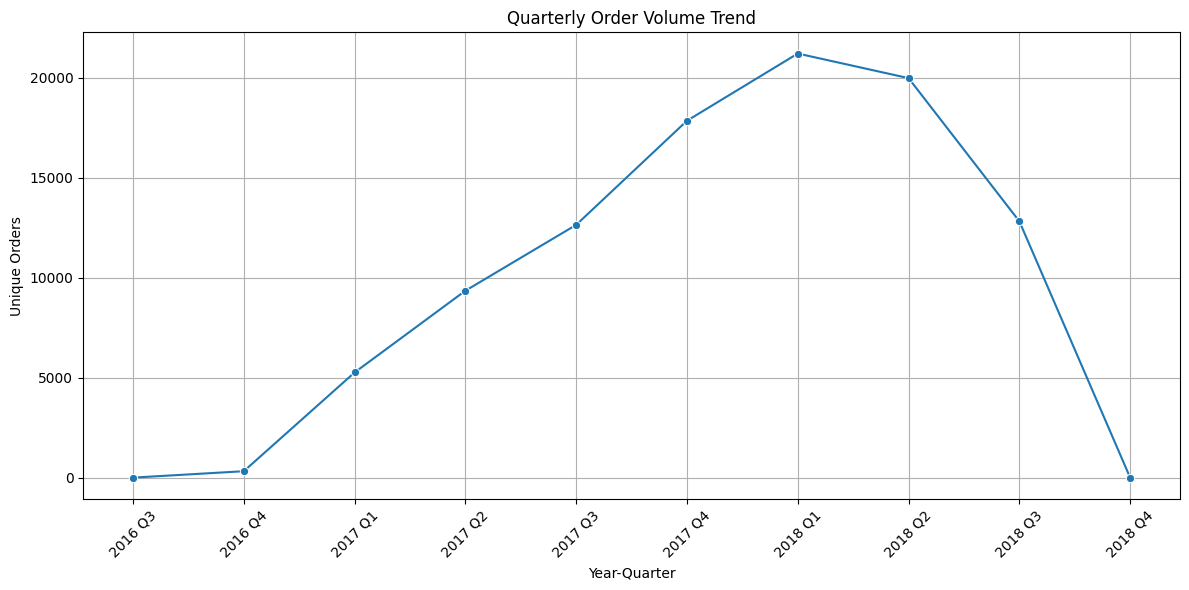

In [14]:
plot_quarterly_order_trend(olist_orders, "order_purchase_timestamp", "order_id")

* *It's monotonous increasing but in 2018 something happens. Need more investigation on that*

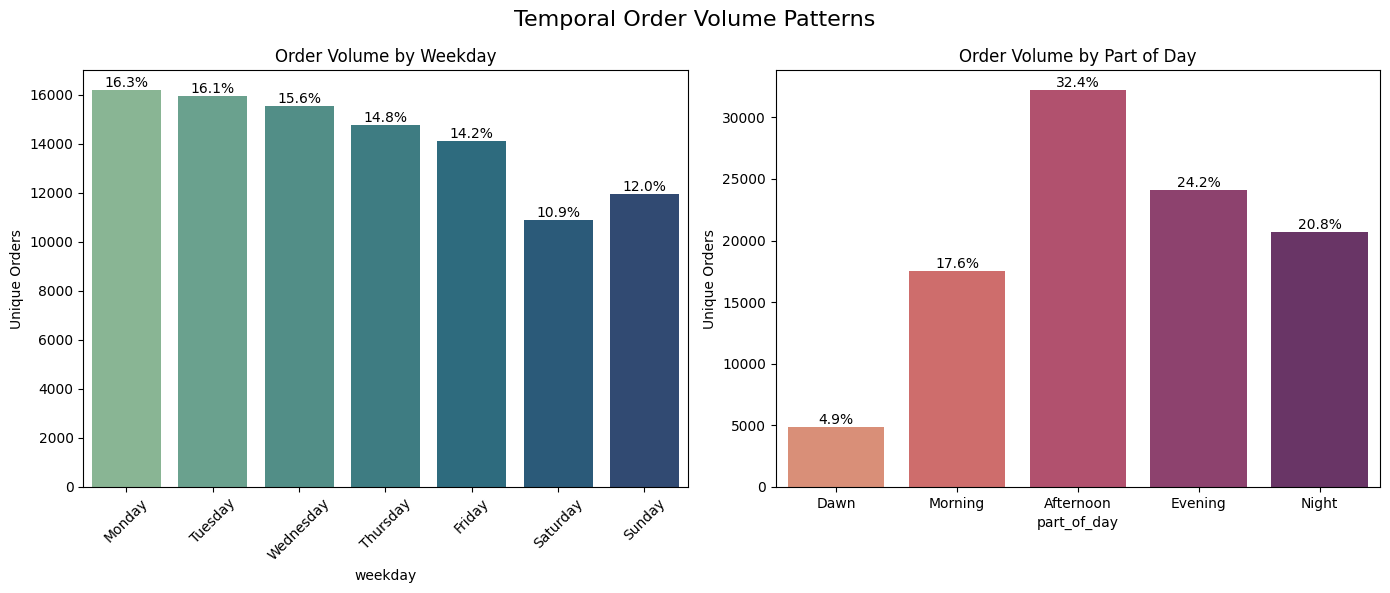

In [15]:
plot_order_volume_patterns(olist_orders, "order_purchase_timestamp", "order_id")

* *Monday are the prefered day for brazilian's customers and they tend to buy more at afternoons(12 pm - 5 pm).*

* *E-commerce: a comparison between 2017 and 2018*

In [16]:
import calendar

def compare_monthly_order_volume(df, order_date_col, order_id_col, years=(2017, 2018)):
    """
    Plots monthly net order volume comparison for given years, with peak highlighted.

    Parameters:
    - df: pandas DataFrame
    - order_date_col: str, datetime column name
    - order_id_col: str, unique order ID column name
    - years: tuple of two years to compare (default 2017, 2018)
    """
    df = df.copy()
    df[order_date_col] = pd.to_datetime(df[order_date_col], errors='coerce')
    df = df.dropna(subset=[order_date_col])

    df['year'] = df[order_date_col].dt.year
    df['month'] = df[order_date_col].dt.month

    # Filter years
    df = df[df['year'].isin(years)]

    # Group
    grouped = (
        df.groupby(['year', 'month'])[order_id_col]
        .nunique()
        .reset_index()
        .rename(columns={order_id_col: 'order_count'})
    )
    grouped['month'] = grouped['month'].apply(lambda x: calendar.month_name[x])


    # Pivot to long format for seaborn
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=grouped, x='month', y='order_count', hue='year', marker='o', palette='tab10')

    # Highlight peak months
    for year in years:
        peak_row = grouped[grouped['year'] == year].sort_values('order_count', ascending=False).iloc[0]
        plt.scatter(peak_row['month'], peak_row['order_count'], s=150, color='red', edgecolor='black', zorder=10)
        plt.text(peak_row['month'], peak_row['order_count'] + 200,
                 f"Peak: {int(peak_row['order_count'])}",
                 ha='center', fontsize=10, color='red')

    plt.title(f"Monthly Net Order Volume Comparison ({years[0]} vs {years[1]})")
    plt.xlabel("Month")
    plt.ylabel("Unique Orders")
    plt.xticks(range(1, 13))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



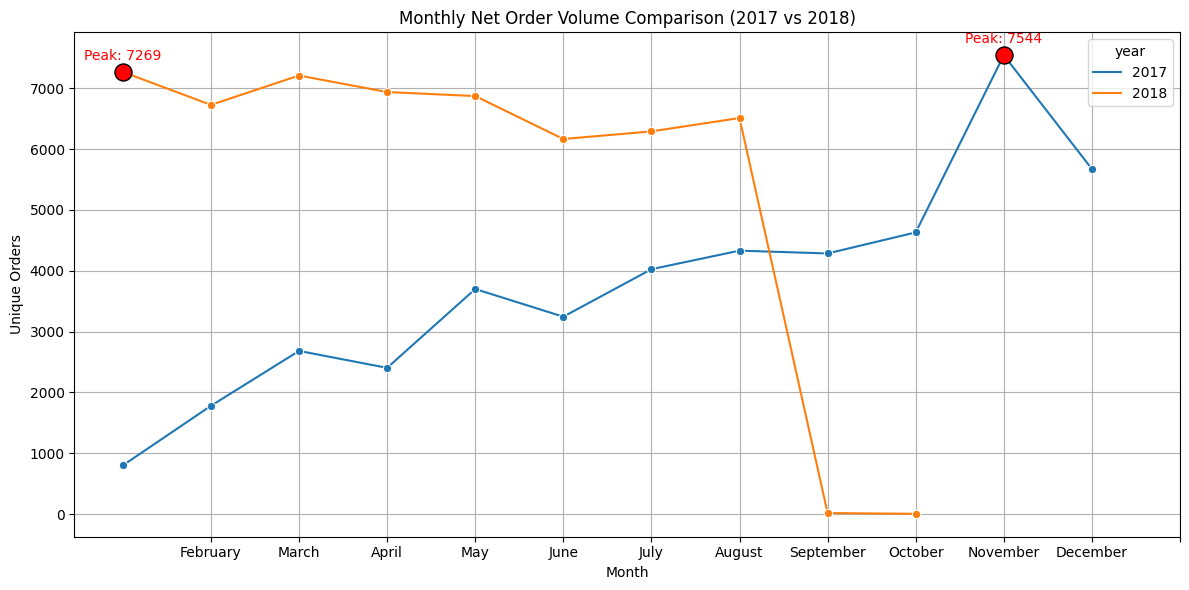

In [17]:
compare_monthly_order_volume(olist_orders, "order_purchase_timestamp", "order_id")

* *something wrong for post august data of 2018. some noise may be. but the growth is visible clearly for 2018 than 2017*

# *E-Commerce Around Brazil*

In [18]:
# Merge orders with customers on customer_id
orders_customers = pd.merge(
    olist_orders,
    olist_customer,
    on='customer_id',
    how='left'
)


In [19]:
def plot_order_distribution_by_location(df, order_id_col, state_col, city_col, top_n_cities=20):
    """
    Plots order volume distribution by customer state and top-N cities (in %).
    
    Parameters:
    - df: pandas DataFrame
    - order_id_col: str, name of unique order ID column
    - state_col: str, name of customer state column
    - city_col: str, name of customer city column
    - top_n_cities: int, number of top cities to plot (default: 20)
    """
    df = df.copy()

    # ----- STATE-LEVEL -----
    state_orders = (
        df.groupby(state_col)[order_id_col]
        .nunique()
        .sort_values(ascending=False)
        .reset_index()
        .rename(columns={order_id_col: 'order_count'})
    )
    state_total = state_orders['order_count'].sum()
    state_orders['pct'] = round((state_orders['order_count'] / state_total) * 100, 2)

    # ----- CITY-LEVEL -----
    city_orders = (
        df.groupby(city_col)[order_id_col]
        .nunique()
        .sort_values(ascending=False)
        .head(top_n_cities)
        .reset_index()
        .rename(columns={order_id_col: 'order_count'})
    )
    city_total = city_orders['order_count'].sum()
    city_orders['pct'] = round((city_orders['order_count'] / city_total) * 100, 2)

    # ----- PLOTTING -----
    fig, axs = plt.subplots(1, 2, figsize=(18, 6))

    sns.barplot(data=state_orders, y=state_col, x='pct', ax=axs[0], palette='crest')
    axs[0].set_title("Order Volume by State (%)")
    axs[0].set_xlabel("Percentage of Orders")
    axs[0].set_ylabel("State")
    for i, row in state_orders.iterrows():
        axs[0].text(row['pct'] + 0.5, i, f"{row['pct']}%", va='center')

    sns.barplot(data=city_orders, y=city_col, x='pct', ax=axs[1], palette='flare')
    axs[1].set_title(f"Top {top_n_cities} Cities by Order Volume (%)")
    axs[1].set_xlabel("Percentage of Orders")
    axs[1].set_ylabel("City")
    for i, row in city_orders.iterrows():
        axs[1].text(row['pct'] + 0.5, i, f"{row['pct']}%", va='center')

    plt.tight_layout()
    plt.show()

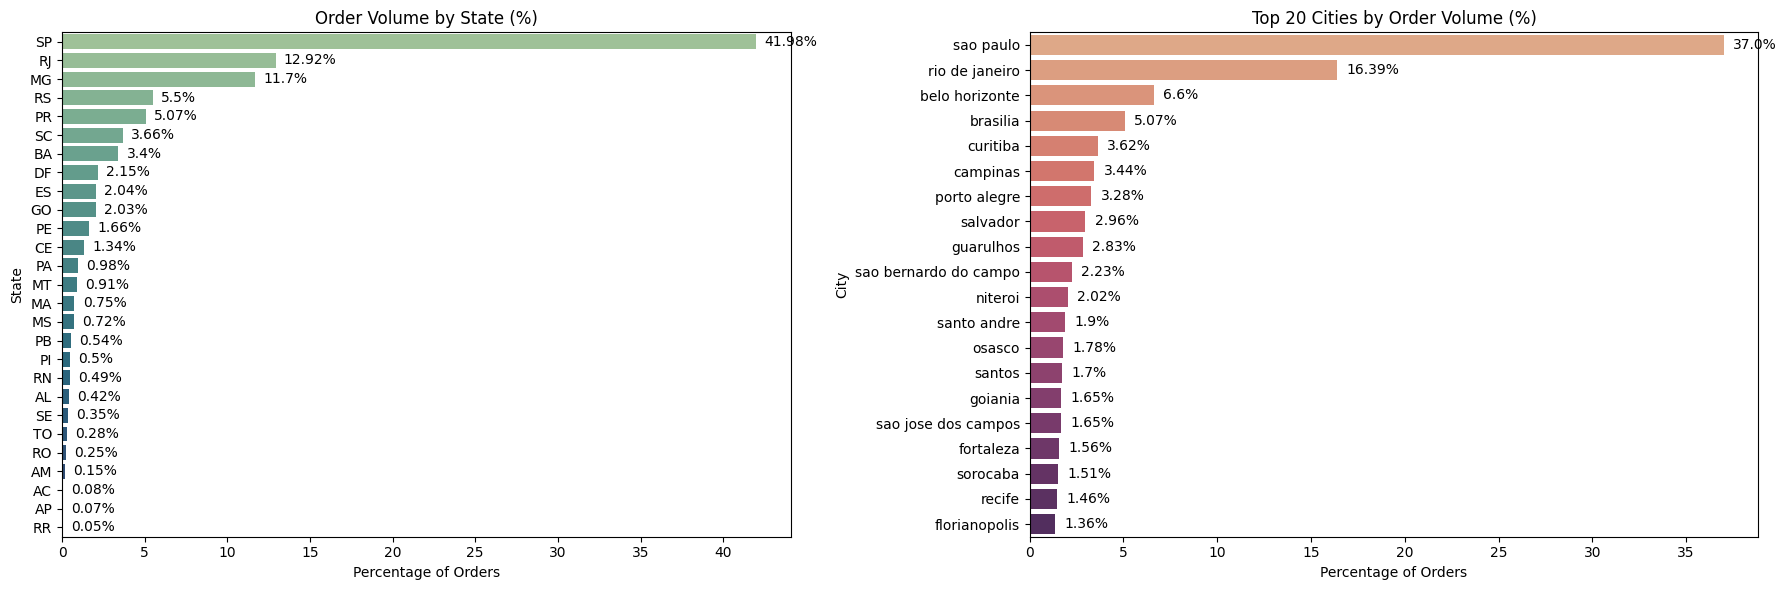

In [20]:
plot_order_distribution_by_location(orders_customers, "order_id","customer_state" , "customer_city")

* *TOP 20 cities order vol is mostly concentrated in sao paulo and rio.*

# *E-Commerce Impact on Economy*

* *How about the e-commerce sales trend?*
* *how about gdp contribution by e-commerce per state?*


In [21]:
# Merge olist_order & olist_order_items

Sales_df = pd.merge(orders_customers, olist_order_items, on = 'order_id', how = "left")


In [22]:
import matplotlib.ticker as mtick

def plot_state_sales(df, sales_col, state_col):
    df = df.copy()


    # Top 10 States by Net Sales Volume ---
    state_sales = df.groupby(state_col)[sales_col].sum().sort_values(ascending=False).head(10).reset_index()
    state_sales['pct'] = 100 * state_sales[sales_col] / state_sales[sales_col].sum()

    plt.figure(figsize=(14, 6))
    ax = sns.barplot(data=state_sales, x=state_col, y=sales_col, palette='Blues_d')
    plt.title('Top 10 States by Net Sales Volume')
    plt.xlabel('State')
    plt.ylabel('Net Sales Volume')

    # Label bars with percentages
    for p in ax.patches:
        height = p.get_height()
        pct = f"{(height / state_sales[sales_col].sum()) * 100:.1f}%"
        ax.annotate(pct, 
                    (p.get_x() + p.get_width() / 2., height), 
                    ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()


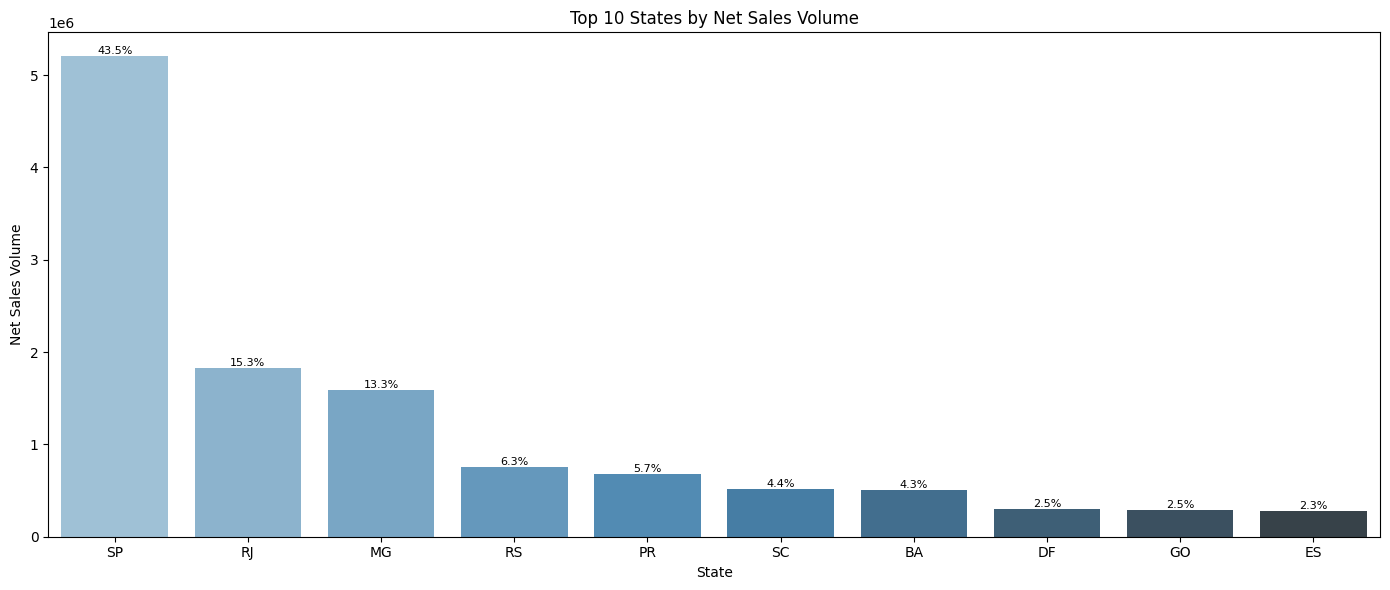

In [23]:
plot_state_sales(Sales_df, "price", "customer_state" )

* *SP has the highest contribution from e-commerce sales*

In [24]:
def format_volume(val):
    if val >= 1e6:
        return f"{val/1e6:.2f}M"
    elif val >= 1e3:
        return f"{val/1e3:.2f}K"
    else:
        return f"{val:.0f}"


def sales_quarterly_trends(df, date_col, sales_col, freight_col):
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    df['quarter'] = df[date_col].dt.to_period('Q')
    df['quarter_str'] = df['quarter'].apply(lambda x: f"Q{x.quarter}-{x.year}")
    df['year'] = df[date_col].dt.year

    # Group quarterly
    grouped = df.groupby('quarter')[ [sales_col, freight_col] ].sum().reset_index()
    grouped['quarter_str'] = grouped['quarter'].apply(lambda x: f"Q{x.quarter}-{x.year}")
    grouped['year'] = grouped['quarter'].dt.year

    # ---- 1. Net Sales Volume Trend ----
    plt.figure(figsize=(12, 5))
    ax = sns.lineplot(data=grouped, x='quarter_str', y=sales_col, marker='o', linewidth=2)
    plt.title('Quarterly Net Sales Volume')
    plt.xlabel('Quarter')
    plt.ylabel('Net Sales')

    # Yearly peaks
    yearly_peaks = grouped.loc[grouped.groupby('year')[sales_col].idxmax()]
    for _, row in yearly_peaks.iterrows():
        ax.axvline(row['quarter_str'], color='orange', linestyle='--', alpha=0.5)
        ax.text(row['quarter_str'], row[sales_col]*1.05, format_volume(row[sales_col]), 
                ha='center', va='bottom', fontsize=8)

    # Total peak
    net_peak = grouped.loc[grouped[sales_col].idxmax()]
    ax.axvline(net_peak['quarter_str'], color='red', linestyle='-', alpha=0.8)
    ax.text(net_peak['quarter_str'], net_peak[sales_col]*1.1, 
            f"Peak: {format_volume(net_peak[sales_col])}",
            color='red', weight='bold', ha='center', fontsize=9)

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # ---- 2. Freight Value Trend ----
    plt.figure(figsize=(12, 5))
    ax = sns.lineplot(data=grouped, x='quarter_str', y=freight_col, marker='s', color='green', linewidth=2)
    plt.title('Quarterly Freight Value')
    plt.xlabel('Quarter')
    plt.ylabel('Freight Value')

    # Yearly peaks
    yearly_peaks_f = grouped.loc[grouped.groupby('year')[freight_col].idxmax()]
    for _, row in yearly_peaks_f.iterrows():
        ax.axvline(row['quarter_str'], color='orange', linestyle='--', alpha=0.5)
        ax.text(row['quarter_str'], row[freight_col]*1.05, format_volume(row[freight_col]), 
                ha='center', va='bottom', fontsize=8)

    # Total peak
    net_peak_f = grouped.loc[grouped[freight_col].idxmax()]
    ax.axvline(net_peak_f['quarter_str'], color='red', linestyle='-', alpha=0.8)
    ax.text(net_peak_f['quarter_str'], net_peak_f[freight_col]*1.1, 
            f"Peak: {format_volume(net_peak_f[freight_col])}",
            color='red', weight='bold', ha='center', fontsize=9)

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # ---- 3. % Change in Net Sales ----
    grouped['sales_pct_change'] = grouped[sales_col].pct_change() * 100

    plt.figure(figsize=(12, 5))
    ax = sns.barplot(data=grouped.iloc[2:], x='quarter_str', y='sales_pct_change', palette='coolwarm')
    plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
    plt.title('% Change in Net Sales per Quarter')
    plt.xlabel('Quarter')
    plt.ylabel('Change (%)')

    for p in ax.patches:
        change = p.get_height()
        label = f"{change:+.1f}%"
        ax.annotate(label, (p.get_x() + p.get_width() / 2., change),
                    ha='center', va='bottom' if change > 0 else 'top', fontsize=8)

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # ---- 4. % Change in Freight Value ----
    grouped['freight_pct_change'] = grouped[freight_col].pct_change() * 100

    plt.figure(figsize=(12, 5))
    ax = sns.barplot(data=grouped.iloc[1:], x='quarter_str', y='freight_pct_change', palette='crest')
    plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
    plt.title('% Change in Freight Value per Quarter')
    plt.xlabel('Quarter')
    plt.ylabel('Change (%)')

    for p in ax.patches:
        change = p.get_height()
        label = f"{change:+.1f}%"
        ax.annotate(label, (p.get_x() + p.get_width() / 2., change),
                    ha='center', va='bottom' if change > 0 else 'top', fontsize=8)

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()




/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



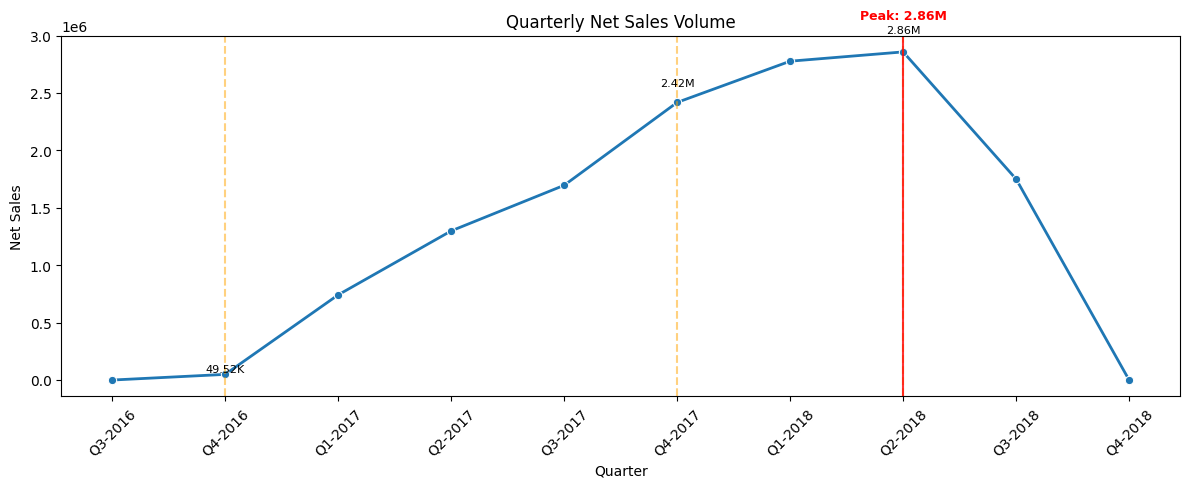

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



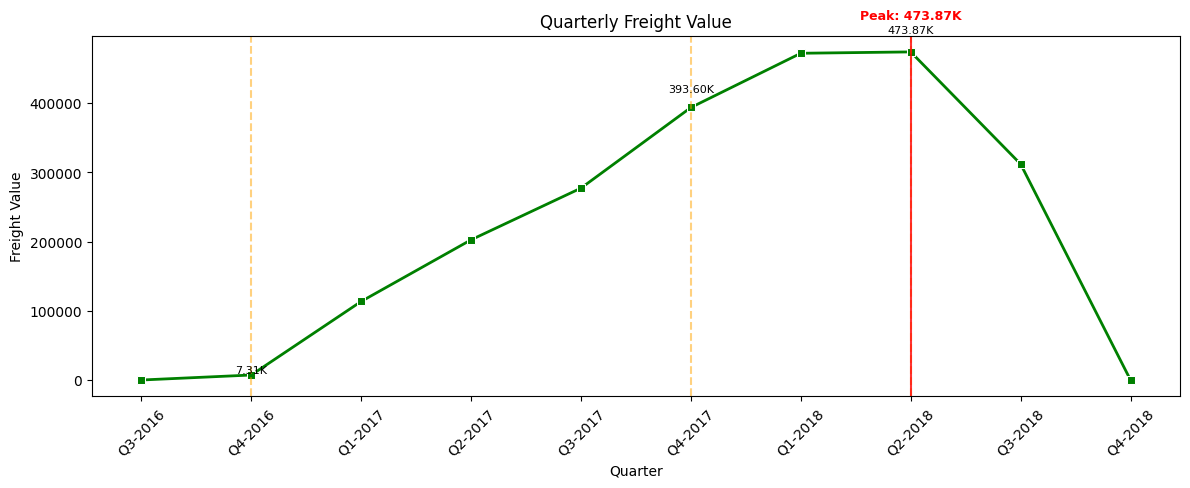

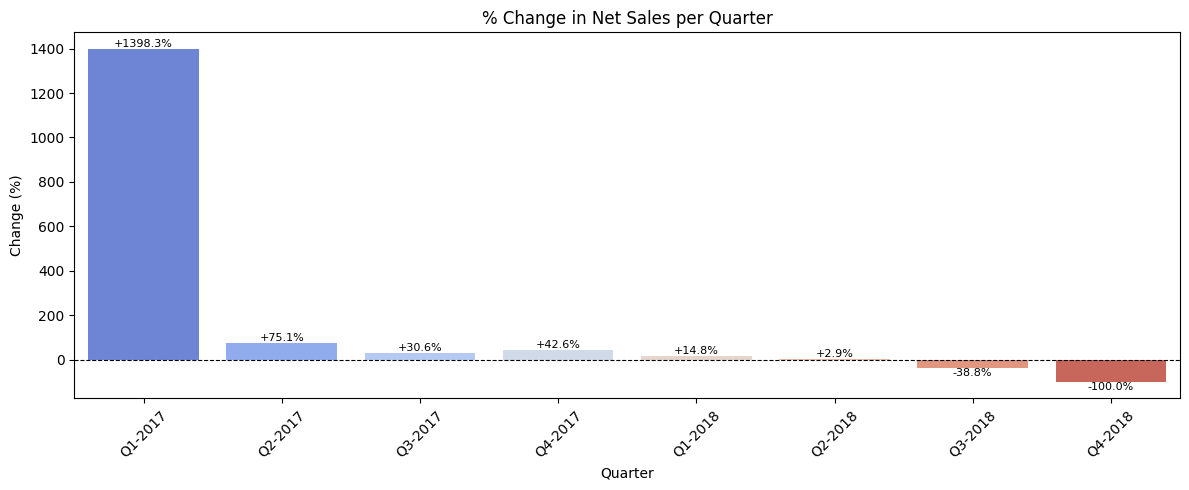

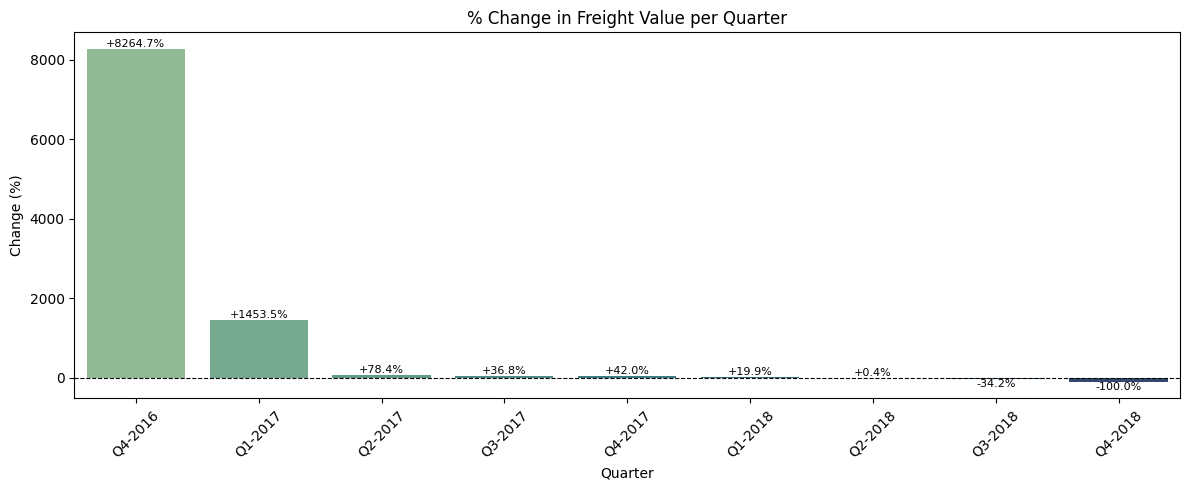

In [25]:
sales_quarterly_trends(Sales_df, "order_purchase_timestamp", "price", "freight_value")

# *PAYMENT EDA*

In [26]:
# merge payment data
payment_df = pd.merge(Sales_df, olist_order_payments, on = 'order_id', how = "left")

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_payment_patterns(df, type_col, inst_col, value_col):
    df = df.copy()

    # --- 1. Payment Type Distribution ---
    type_dist = df[type_col].value_counts(normalize=True).reset_index()
    type_dist.columns = [type_col, 'pct']
    type_dist['count'] = df[type_col].value_counts().values

    plt.figure(figsize=(10, 5))
    ax = sns.barplot(data=type_dist, x=type_col, y='pct', palette='viridis')
    plt.title('Payment Type Distribution')
    plt.ylabel('Percentage')
    plt.xlabel('Payment Type')
    
    for p, val in zip(ax.patches, type_dist['pct']):
        ax.annotate(f"{val*100:.1f}%", 
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()

    # --- 2. Payment Installments Pattern ---
    inst_dist = df[inst_col].value_counts(normalize=True).sort_index().reset_index()
    inst_dist.columns = [inst_col, 'pct']
    inst_dist['count'] = df[inst_col].value_counts().sort_index().values

    plt.figure(figsize=(12, 5))
    ax = sns.barplot(data=inst_dist, x=inst_col, y='pct', palette='magma')
    plt.title('Installments Distribution')
    plt.ylabel('Percentage')
    plt.xlabel('Installment Count')
    
    for p, val in zip(ax.patches, inst_dist['pct']):
        ax.annotate(f"{val*100:.1f}%", 
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()

    # --- 3. Correlation: Payment Value vs. Payment Type ---
    plt.figure(figsize=(12, 6))
    ax = sns.boxplot(data=df, x=type_col, y=value_col, palette='coolwarm')
    plt.title('Payment Value by Payment Type')
    plt.ylabel('Payment Value')
    plt.xlabel('Payment Type')
    plt.yscale('log')  # log scale to show spread better
    plt.tight_layout()
    plt.show()




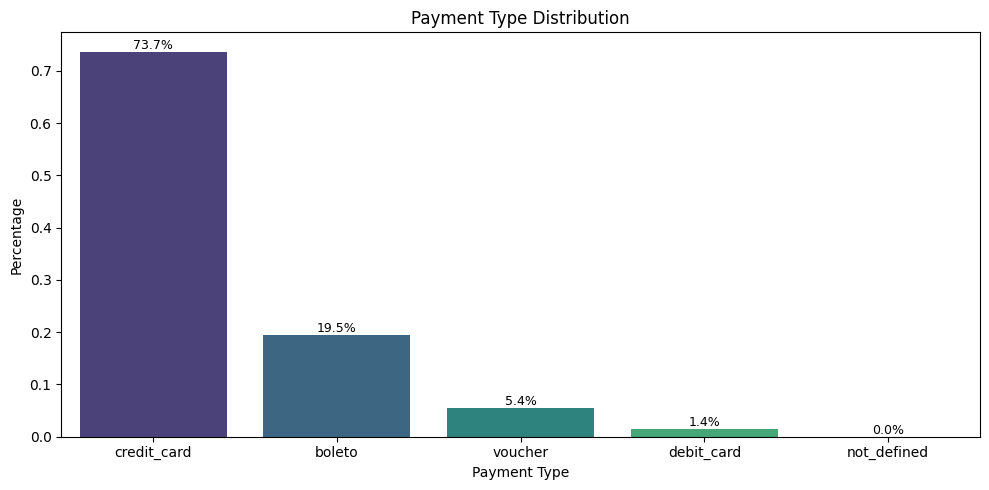

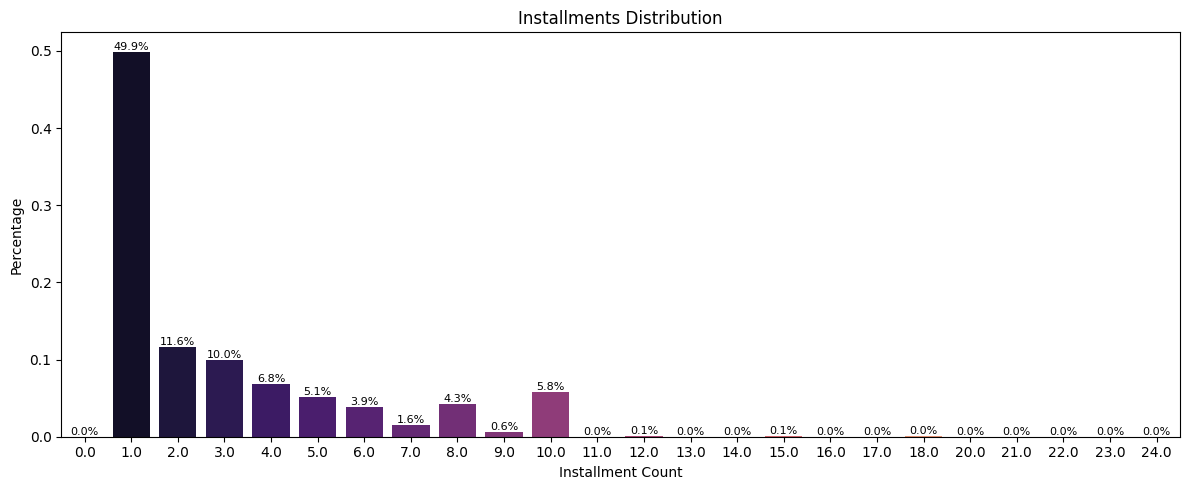

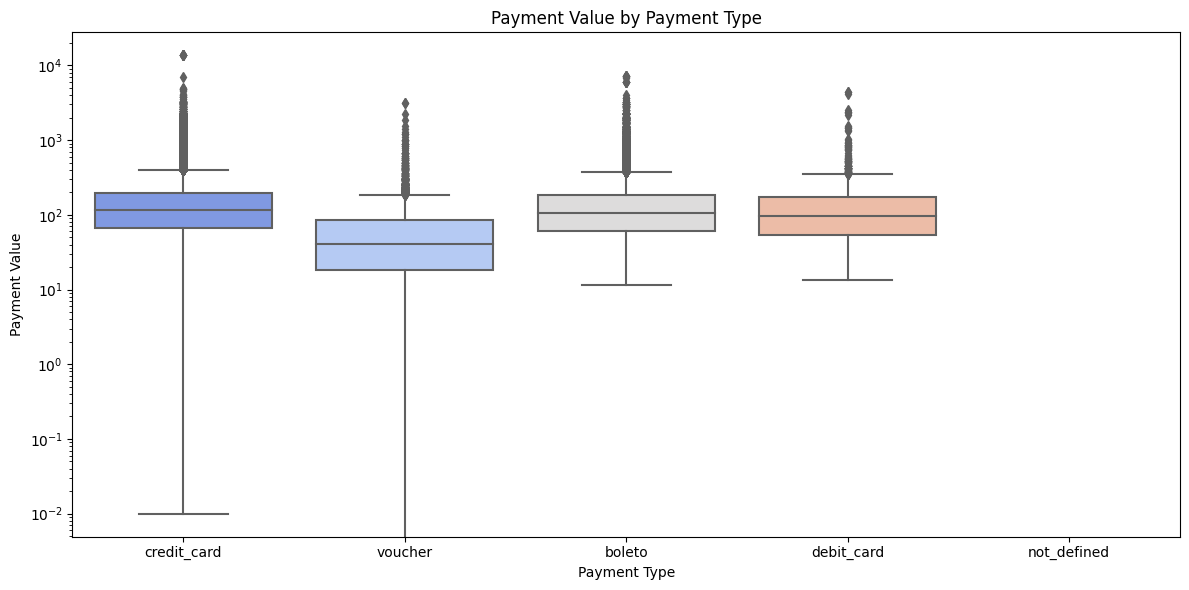

In [28]:
plot_payment_patterns(payment_df, "payment_type", "payment_installments", "payment_value")

* *so Brazillians mostly use credit card.*
* *there isn't any specific correlation of payment method and payment values. Even for low value credit card is the payment method.*

# **SENTIMENT ANALYSIS**

In [29]:
# clustering customers based on their reviews scores
# product clustering based on review - can be done just by groupby of review score.
# seller clustering accordingly
# clustering based on review comments.
# what about those who didn't write comments?


In [30]:
df_comments = olist_order_reviews.loc[:, ['review_score', 'review_comment_message']]
df_comments = df_comments.dropna(subset=['review_comment_message'])
df_comments = df_comments.reset_index(drop=True)
print(f'Dataset shape: {df_comments.shape}')
df_comments.columns = ['score', 'comment']
df_comments.head()

Dataset shape: (40977, 2)


,score,comment
0,5,Recebi bem antes do prazo estipulado.
1,5,Parabéns lojas lannister adorei comprar pela I...
2,4,aparelho eficiente. no site a marca do aparelh...
3,4,"Mas um pouco ,travando...pelo valor ta Boa.\r\n"
4,5,"Vendedor confiável, produto ok e entrega antes..."


* *1. getting rid of breakline and carriage return*

In [31]:
def re_breakline(text_list):
    """
    text_list: list object with text content to be prepared [type: list]
    """
    # Applying regex
    return [re.sub('[\n\r]', ' ', r).strip() for r in text_list]

# Creating a list of comment reviews
reviews = list(df_comments['comment'].values)

# Applying RegEx
reviews_breakline = re_breakline(reviews)
df_comments['re_breakline'] = reviews_breakline


* *2. getting rid of hyperlinks and sites*

In [32]:
def re_hiperlinks(text_list):
    """
    Args:
    ----------
    text_list: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    pattern = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    return [re.sub(pattern, ' link ', r) for r in text_list]


reviews_hiperlinks = re_hiperlinks(reviews_breakline)
df_comments['re_hiperlinks'] = reviews_hiperlinks


* *3. comments may have dates. let's change it into data - keyword.*

In [33]:
def re_dates(text_list):
    """
    Args:
    ----------
    text_list: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    pattern = '([0-2][0-9]|(3)[0-1])(\/|\.)(((0)[0-9])|((1)[0-2]))(\/|\.)\d{2,4}'
    return [re.sub(pattern, ' data ', r) for r in text_list]

reviews_dates = re_dates(reviews_hiperlinks)
df_comments['re_dates'] = reviews_dates

* *4. change the money expression into keyword - valor*

In [34]:
def re_money(text_list):
    """
    Args:
    ----------
    text_list: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    pattern = '[R]{0,1}\$[ ]{0,}\d+(,|\.)\d+'
    return [re.sub(pattern, ' dinheiro ', r) for r in text_list]

# Applying RegEx
reviews_money = re_money(reviews_dates)
df_comments['re_money'] = reviews_money



* *5. change numbers by keyword - numero*

In [35]:
def re_numbers(text_list):
    """
    Args:
    ----------
    text_series: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    return [re.sub('[0-9]+', ' numero ', r) for r in text_list]

# Applying RegEx
reviews_numbers = re_numbers(reviews_money)
df_comments['re_numbers'] = reviews_numbers

* ***6. 'Not' ---> is a crucial word for sentimental analysis. change it into keyword - negação so we don't loose them in stopwords***

In [36]:
def re_negation(text_list):
    """
    Args:
    ----------
    text_series: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    return [re.sub('([nN][ãÃaA][oO]|[ñÑ]| [nN] )', ' negação ', r) for r in text_list]


# Applying RegEx
reviews_negation = re_negation(reviews_numbers)
df_comments['re_negation'] = reviews_negation



* *7. special characters - emojis :)*

In [37]:
def re_special_chars(text_list):
    """
    Args:
    ----------
    text_series: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    return [re.sub('\W', ' ', r) for r in text_list]


reviews_special_chars = re_special_chars(reviews_negation)
df_comments['re_special_chars'] = reviews_special_chars

* *8. white spaces*

In [38]:
def re_whitespaces(text_list):
    """
    Args:
    ----------
    text_series: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    white_spaces = [re.sub('\s+', ' ', r) for r in text_list]
    white_spaces_end = [re.sub('[ \t]+$', '', r) for r in white_spaces]
    return white_spaces_end

# Applying RegEx
reviews_whitespaces = re_whitespaces(reviews_special_chars)
df_comments['re_whitespaces'] = reviews_whitespaces

**STOPWORDS**

In [39]:
# Examples of some portuguese stopwords
pt_stopwords = stopwords.words('portuguese')
print(f'Total portuguese stopwords in the nltk.corpous module: {len(pt_stopwords)}')
pt_stopwords[:10]

Total portuguese stopwords in the nltk.corpous module: 207


['a',
 'à',
 'ao',
 'aos',
 'aquela',
 'aquelas',
 'aquele',
 'aqueles',
 'aquilo',
 'as']

In [40]:
# Defining a function to remove the stopwords and to lower the comments
def stopwords_removal(text, cached_stopwords=stopwords.words('portuguese')):
    """
    text: list object where the stopwords will be removed [type: list]
    cached_stopwords: stopwords to be applied on the process [type: list, default: stopwords.words('portuguese')]
    """
    
    return [c.lower() for c in text.split() if c.lower() not in cached_stopwords]

In [41]:
reviews_stopwords = [' '.join(stopwords_removal(review)) for review in reviews_whitespaces]
df_comments['stopwords_removed'] = reviews_stopwords

**STEMMING**

In [42]:
# Defining a function to remove the stopwords and to lower the comments
def stemming_process(text, stemmer=RSLPStemmer()):
    """
    Args:
    ----------
    text: list object where the stopwords will be removed [type: list]
    stemmer: type of stemmer to be applied [type: class, default: RSLPStemmer()]
    """
    
    return [stemmer.stem(c) for c in text.split()]

In [43]:
reviews_stemmer = [' '.join(stemming_process(review)) for review in reviews_stopwords]
df_comments['stemming'] = reviews_stemmer

**FEATURE EXTRACTION**

In [44]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def extract_text_features(df, text_col, mode='tfidf', max_features=500):
    """
    Extracts Bag-of-Words or TF-IDF features from a text column and appends to the DataFrame.
    
    Args:
        df (pd.DataFrame): The input dataframe
        text_col (str): Column name containing text
        mode (str): 'bow' for Bag-of-Words or 'tfidf' for TF-IDF
        max_features (int): Max number of features to keep
    
    Returns:
        pd.DataFrame: Original dataframe with new features attached
    """
    
    df = df.copy()
    text_data = df[text_col].astype(str).fillna("")

    if mode == 'bow':
        vectorizer = CountVectorizer(max_features=max_features)
    elif mode == 'tfidf':
        vectorizer = TfidfVectorizer(max_features=max_features, ngram_range = (1, 3))
    else:
        raise ValueError("mode must be either 'bow' or 'tfidf'")

    feature_matrix = vectorizer.fit_transform(text_data)
    feature_df = pd.DataFrame(feature_matrix.toarray(), 
                              columns=[f"{mode}_{f}" for f in vectorizer.get_feature_names_out()],
                              index=df.index)


    return feature_df


In [45]:
feature_df = extract_text_features(df_comments, 'stemming', mode='tfidf', max_features=500)

In [46]:
def bar_percent(df, col, show_pct_labels=True, order=None, palette='pastel'):
    # Get value counts as percentages
    pct = df[col].value_counts(normalize=True) * 100
    
    if order is not None:
        pct = pct.loc[order]
    else:
        pct = pct.sort_values(ascending=False)

    # Create DataFrame to preserve order for plotting and labels
    pct_df = pct.reset_index()
    pct_df.columns = [col, 'pct']

    # Plot
    plt.figure(figsize=(max(6, len(pct_df)*0.7), 5))
    ax = sns.barplot(data=pct_df, x=col, y='pct', palette=palette)
    plt.title(f'Percentage Distribution of {col}', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Percentage (%)', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add percentage labels
    for patch in ax.patches:
        height = patch.get_height()
        ax.annotate(f'{height:.1f}%', 
                    (patch.get_x() + patch.get_width() / 2, height),
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


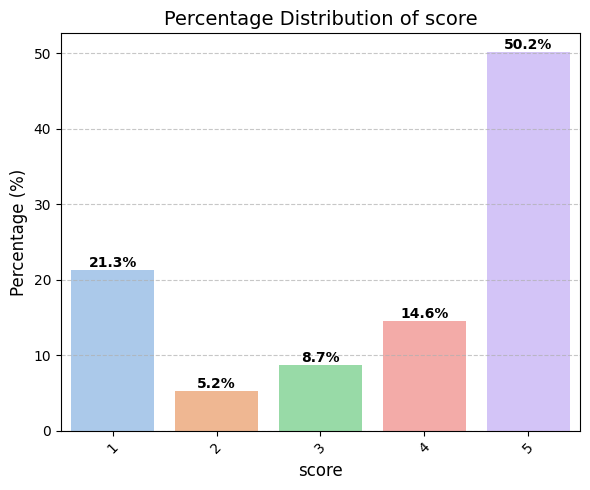

In [47]:
bar_percent(df_comments, 'score')

* *it can be segmented into two category - (1, 2, 3) - neg comment and (4, 5) - positive comment*
* *this would be our labels for supervised learning*
* *model would predict whether a review comment is neg or pos.*

In [48]:
def label_sentiment(df, score_col='score', new_col='sentiment'):
    df = df.copy()
    df[new_col] = df[score_col].apply(lambda x: 1 if x >= 4 else 0)
    return df

In [49]:
df_sentiment = label_sentiment(df_comments, 'score')

In [50]:
model_data = pd.concat([df_sentiment['sentiment'], feature_df], axis = 1)

# *Feature importance plots*

In [51]:
def plot_feature_importance_by_class(X, y, top_n=20):
    """
    Plots top features correlated with class 1 and 0 based on their mean tf-idf/BoW values.
    
    Args:
        X (pd.DataFrame): Feature matrix (TF-IDF or BoW, with tokens as column names)
        y (pd.Series or array): Binary sentiment labels (0/1)
        top_n (int): Number of top features to display per class
    """

    # Combine X and y
    df = X.copy()
    df['sentiment'] = y

    # Compute class-wise mean feature values
    class_0_means = df[df['sentiment'] == 0].drop(columns='sentiment').mean()
    class_1_means = df[df['sentiment'] == 1].drop(columns='sentiment').mean()

    # Get top N for each
    top0 = class_0_means.sort_values(ascending=False).head(top_n)
    top1 = class_1_means.sort_values(ascending=False).head(top_n)

    # Plot
    plt.figure(figsize=(14, 5))

    # Class 1
    plt.subplot(1, 2, 1)
    sns.barplot(x=top1.values, y=top1.index, palette='crest')
    plt.title(f'Top {top_n} Features for Sentiment = 1 (Positive)', fontsize=12)
    plt.xlabel('Mean TF-IDF Score')
    plt.ylabel('Feature')

    # Class 0
    plt.subplot(1, 2, 2)
    sns.barplot(x=top0.values, y=top0.index, palette='flare')
    plt.title(f'Top {top_n} Features for Sentiment = 0 (Negative)', fontsize=12)
    plt.xlabel('Mean TF-IDF Score')
    plt.ylabel('')

    plt.tight_layout()
    plt.show()


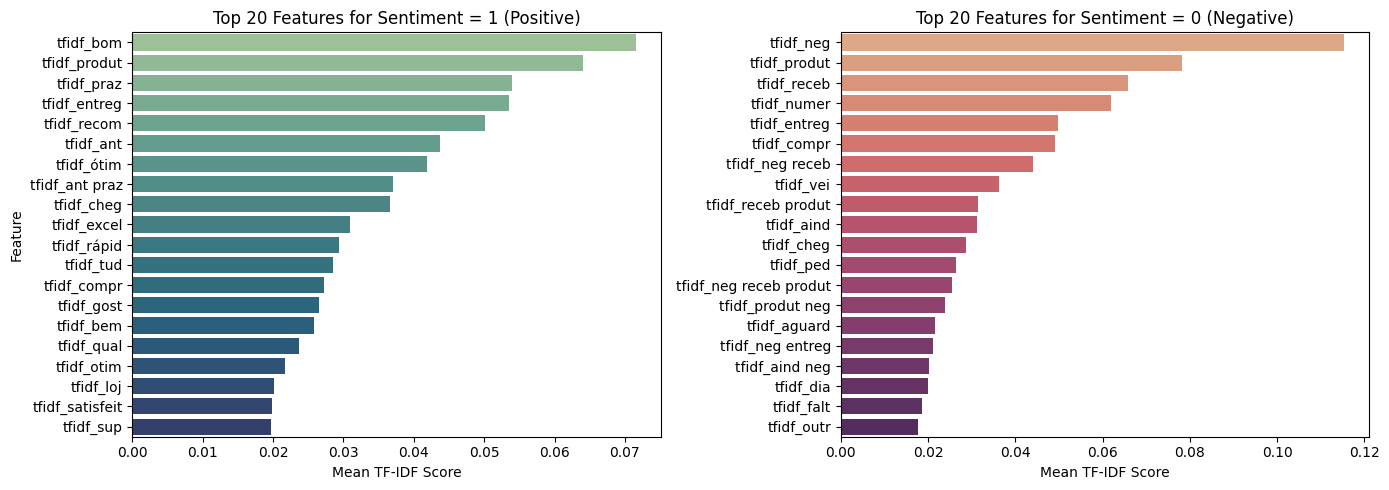

In [52]:
plot_feature_importance_by_class(model_data.drop(['sentiment'], axis = 1), model_data['sentiment'])



* *NOW WE HAVE TO BUILD OUR MODEL PIPELINE*
* *This is a classification problem*

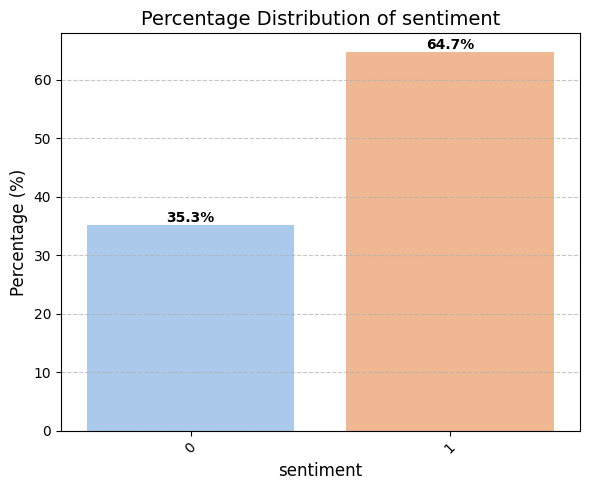

In [53]:
bar_percent(model_data, 'sentiment')

* *It's not terribly imbalanced. We can jump into model training.*

* *LET'S HAVE ALL THE NECESSARY FUNCTIONS. modular - baby!!*

In [54]:
# spliting the data into train and test
def split(df, target_col):
    X = df.drop([target_col], axis = 1)
    y = df[target_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, stratify=y, random_state= 42)
    return X_train, X_test, y_train, y_test

# training with models. 

def train_multiple_models(X_train, y_train, feature_space, models_dict):
    """
    Trains multiple models and returns a dict of fitted models.

    Parameters:
    -----------
    X_train : pd.DataFrame or np.ndarray
        Training features.
    y_train : pd.Series or np.ndarray
        Training target.
    feature_space = list of cols
    models_dict : dict
        Dictionary of model_name: model_instance.

    Returns:
    --------
    dict
        Dictionary of model_name: trained_model.
    """
    trained_models = {}
    for name, model in models_dict.items():
        print(f"Training: {name}")
        X_train_ready = X_train[feature_space]
        model.fit(X_train_ready, y_train)
        trained_models[name] = model
    return trained_models


# evaluation metrics

def evaluate_models(X_test, y_test, trained_models: dict, metrics: dict):
    """
    Evaluates multiple trained classification models on X_test and y_test.

    Parameters:
        X_test (pd.DataFrame): Test features.
        y_test (pd.Series): True test labels.
        trained_models (dict): Model name -> trained model object.
        metrics (dict): Metric name -> metric function.

    Returns:
        pd.DataFrame: Rows = model names, Columns = metric scores.
    """
    results = {}

    for model_name, model in trained_models.items():
        print(f"Evaluating: {model_name}")
        y_pred = model.predict(X_test)

        # Try to get predicted probabilities for metrics like ROC AUC
        try:
            y_proba = model.predict_proba(X_test)[:, 1]
        except:
            y_proba = None

        scores = {}
        for metric_name, metric_func in metrics.items():
            if metric_name == "roc_auc" and y_proba is not None:
                score = metric_func(y_test, y_proba)
            else:
                score = metric_func(y_test, y_pred)
            scores[metric_name] = round(score, 4)

        results[model_name] = scores

    return pd.DataFrame(results).T


# plotting confusion metrics for models.

from sklearn.metrics import confusion_matrix, accuracy_score

def plot_confusion_matrices(x_test, y_test, models_dict):
    """
    Plots confusion matrices for multiple trained models.
    
    Parameters:
    x_test (array-like): Features for testing.
    y_test (array-like): True labels.
    models_dict (dict): Dictionary with model names as keys and trained model objects as values.
    """
    n_models = len(models_dict)
    n_cols = 2
    n_rows = (n_models + 1) // n_cols

    plt.figure(figsize=(6 * n_cols, 5 * n_rows))

    for i, (name, model) in enumerate(models_dict.items(), 1):
        y_pred = model.predict(x_test)
        cm = confusion_matrix(y_test, y_pred)
        acc = accuracy_score(y_test, y_pred)

        plt.subplot(n_rows, n_cols, i)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f'{name} (Acc: {acc:.2%})')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')

    plt.tight_layout()
    plt.show()



In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

model_dict = {
    'LogisticRegression': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(scale_pos_weight=10, use_label_encoder=False, eval_metric='logloss', random_state=42),
    'LightGBM': LGBMClassifier(class_weight='balanced', random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

metric_dict = {
    'accuracy': accuracy_score,
    'precision': lambda y_true, y_pred: precision_score(y_true, y_pred, zero_division=0),
    'recall': recall_score,
    'f1': f1_score,
    'roc_auc': roc_auc_score
}

* *NOW - WE ARE READY*

In [56]:
X_train, X_test, y_train, y_test = split(model_data, 'sentiment')

In [57]:
feature_space = X_train.columns
trained_models = train_multiple_models(X_train, y_train, feature_space, model_dict)

Training: LogisticRegression
Training: RandomForest
Training: GradientBoosting
Training: XGBoost
Training: LightGBM
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 21224, number of negative: 11557
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049120 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 51362
[LightGBM] [Info] Number of data points in the train set: 32781, number of used features: 500
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training: KNN


In [58]:
scores = evaluate_models(X_test, y_test, trained_models, metric_dict)
scores

Evaluating: LogisticRegression
Evaluating: RandomForest
Evaluating: GradientBoosting
Evaluating: XGBoost
Evaluating: LightGBM
Evaluating: KNN


,accuracy,precision,recall,f1,roc_auc
LogisticRegression,0.8896,0.9333,0.8933,0.9129,0.9431
RandomForest,0.8895,0.9137,0.9158,0.9147,0.9372
GradientBoosting,0.8603,0.8599,0.9369,0.8967,0.9240
XGBoost,0.8278,0.8000,0.9787,0.8804,0.9385
LightGBM,0.8886,0.9298,0.8956,0.9124,0.9414
KNN,0.8377,0.8369,0.9306,0.8813,0.8596


* *Logistic regression rocks here.*
* *If the false positive is high i.e. if the review is neg and model predicts pos, it hurts most.*

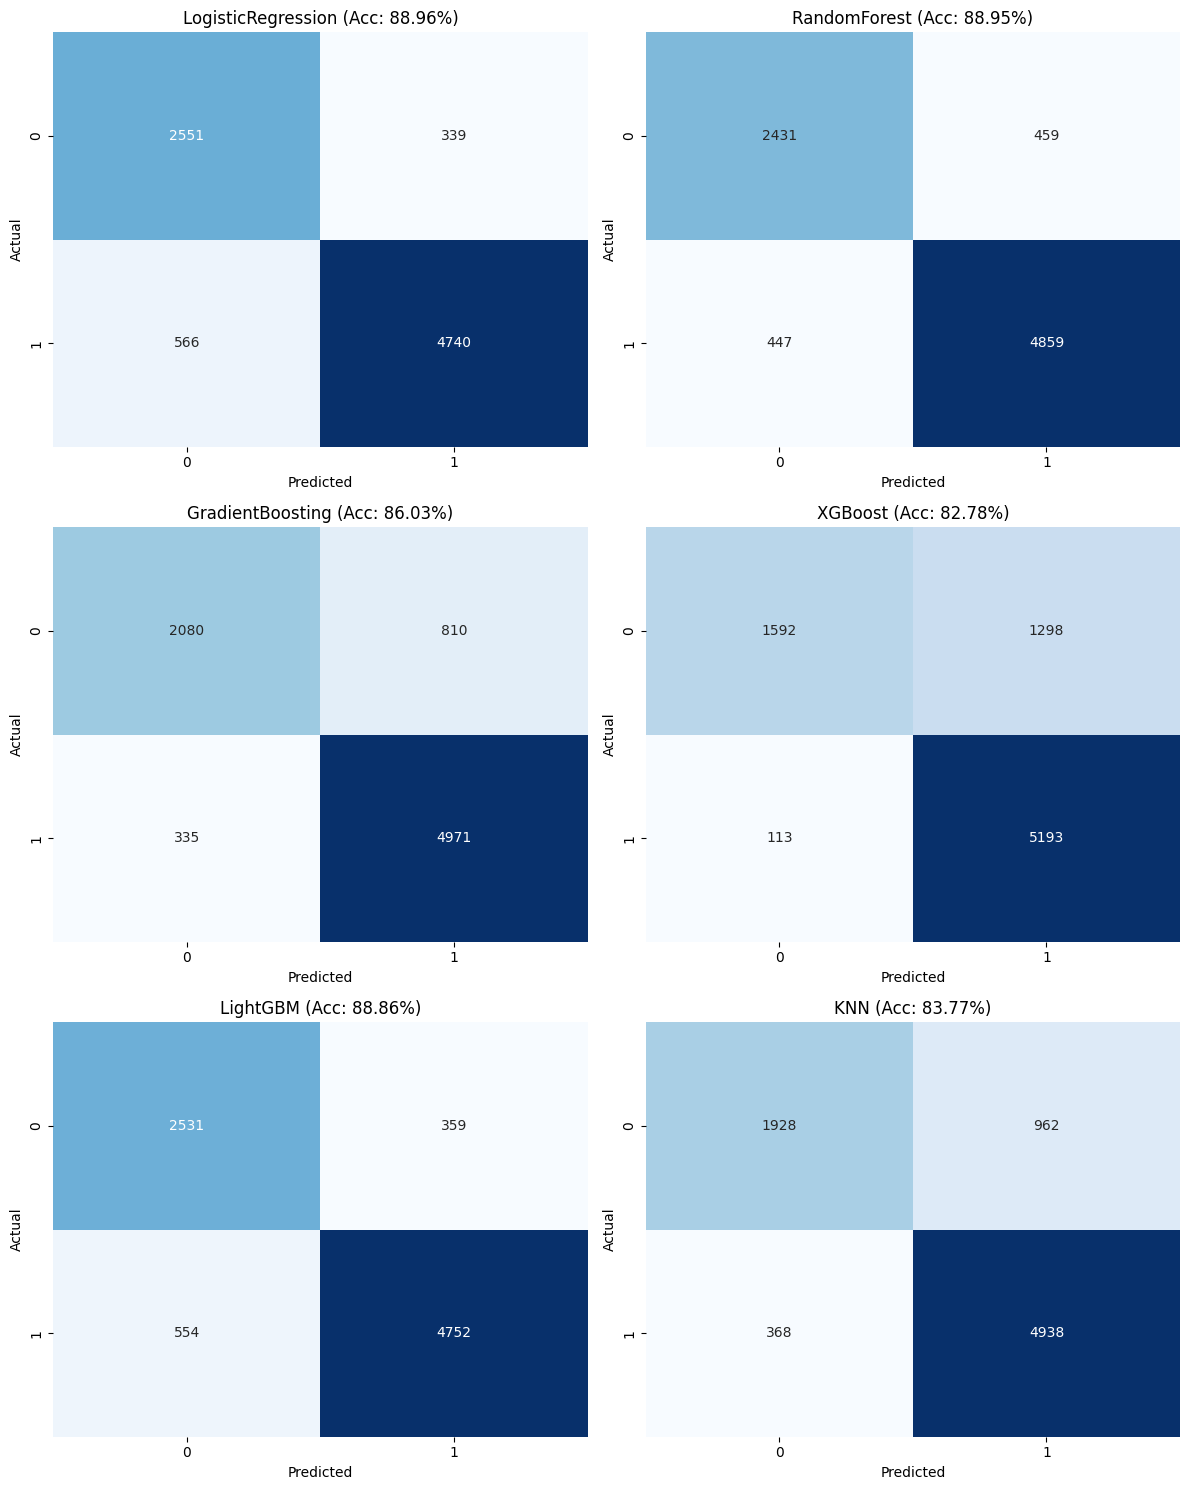

In [59]:
plot_confusion_matrices(X_test, y_test, trained_models)